# Compute $a_0$ by comparing with $\eta$

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV

from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart


import pymc3 as pm
from theano import shared
from theano import tensor as tt

import matplotlib as mpl

import yaml

In [2]:
%matplotlib notebook

# Load the pre-computed amplitude data

$a_0$ is found here via nonlinear optimization of the KdV model in 24-hr time blocks.

In [3]:
# Load the pre-computed data
csvfile = '../data/ekdv_Prelude_results.csv'

# This is the good file!!!

data = pd.read_csv(csvfile, sep=',', parse_dates=['time','timemax'], index_col='time')

data.head()

,timemax,Amax,beta0,beta1,beta2,beta3,beta4,beta5,a0,Ls,alpha,C
time,,,,,,,,,,,,
2016-05-01,2016-05-01 22:49:00,-17.517,1023.464,1.281,59.462,25.583,83.175,44.421,13.2348,141013.7572,-0.0090,1.5329
2016-05-02,2016-05-02 17:26:00,-16.563,1023.489,1.281,59.431,27.549,84.906,47.735,13.2975,143267.6647,-0.0087,1.5246
2016-05-03,2016-05-03 20:50:00,19.584,1023.489,1.281,59.800,26.636,84.889,50.688,15.8858,116052.2453,-0.0089,1.5188
2016-05-04,2016-05-04 23:28:00,25.726,1023.505,1.283,59.814,27.861,86.798,53.998,17.0912,109527.4289,-0.0087,1.5119
2016-05-05,2016-05-05 18:50:00,-26.879,1023.528,1.282,60.298,29.466,86.836,56.151,17.3610,108830.8088,-0.0086,1.5088


In [4]:
# Load the density data (we need the time from this for our prediction later...)
datadir = '../../run_ddcurves/DATA_SHELL/'
densityh5file = '%s/Crux_KP150_12mth_Density_lowpass_beta-samples-array-all-data.h5'%datadir
densitycsv = '%s/Crux_KP150_12mth_Density_lowpass.csv'%datadir

rhodata = pd.read_csv(densitycsv,sep=', ',index_col='Time', parse_dates=['Time'])
rhodata.head()

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,-250.5,-227.8,-203.6,-179.4,-155.2,-131.0,-106.8,-82.6,-58.4,-34.2,-9.7
Time,,,,,,,,,,,
2016-04-29 23:15:00,1026.1856,1025.8925,1025.7143,1025.2657,1024.6332,1023.9980,1023.6147,1023.2060,1022.7400,1021.5415,1021.0069
2016-04-30 05:15:00,1026.1849,1025.8863,1025.7151,1025.3660,1024.8013,1024.1201,1023.6627,1023.1954,1022.5800,1021.3722,1021.0062
2016-04-30 11:15:00,1026.1869,1025.8835,1025.7203,1025.4548,1024.9521,1024.2258,1023.7043,1023.1845,1022.4485,1021.2284,1021.0056
2016-04-30 17:15:00,1026.1911,1025.8849,1025.7290,1025.5233,1025.0700,1024.3037,1023.7364,1023.1761,1022.3568,1021.1229,1021.0056
2016-04-30 23:15:00,1026.1960,1025.8902,1025.7398,1025.5688,1025.1493,1024.3510,1023.7589,1023.1719,1022.3046,1021.0573,1021.0063


<IPython.core.display.Javascript object>


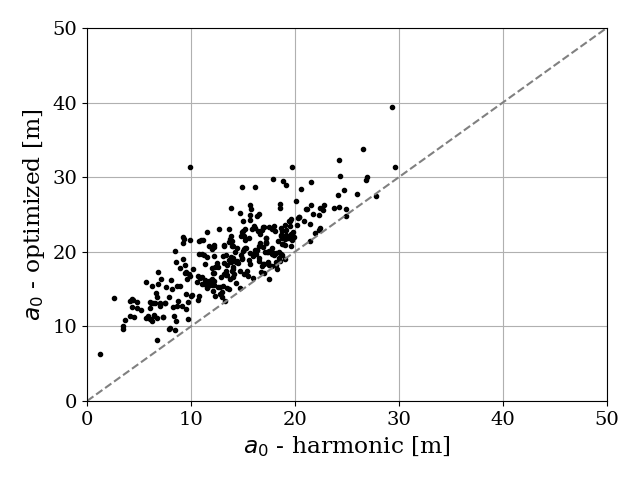

In [5]:
# Load the tidal harmonic estimate of a_0

# Load the amplitude and density data

ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode=0
ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two
A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan
a0.loc['2016-09-18':'2016-10-31']=np.nan

# Create a time series of single days with the max amplitude and a guess at beta
#time1 = pd.date_range('2016-5-1','2016-9-15') 
#time2 = pd.date_range('2016-11-1','2017-5-1')

#time = time1.append(time2)
basetime = datetime(2016,1,1)

a0_harmonic = a0.sel(timeslow=data.index, method='nearest')
tdays_a0 = SecondsSince(a0_harmonic.timeslow.values,basetime=basetime)/86400.
a0_harmonic.timeslow.values
#a0.sel(timeslow=data.index,method='nearest')

plt.figure()
plt.plot(a0_harmonic, data['a0'], 'k.')
plt.plot([0,50],[0,50],'--',c='0.5')
plt.ylabel('$a_0$ - optimized [m]')
plt.xlabel('$a_0$ - harmonic [m]' )
plt.xlim(0,50)
plt.ylim(0,50)
plt.grid(b=True)
plt.tight_layout()

# Extract the tides at a point

In [6]:
# Load the tidal velocity
xpt, ypt = 123.346383, -13.75895

# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']

#tidecons = ['M2','S2',]

# This extract_phsamp function appears to be wrong so manually calculate the phase and amp

ua,up,va,vp,ha,hp,omega = readotps.extract_phsamp(tidemod,np.array([xpt]),
                        np.array([ypt]),basetime, tidecons)
ha,hp

Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


(array([[0.57964943],
        [0.33657617],
        [0.10025383],
        [0.09720097],
        [0.12495775],
        [0.07640952],
        [0.03686202],
        [0.01721223]]), array([[23.84678916],
        [22.86826952],
        [24.28115772],
        [22.89947381],
        [21.9160733 ],
        [22.1170623 ],
        [21.97286271],
        [22.23507661]]))

In [10]:
# Extract the tidal height for the whole period
time = TimeVector('20160501.000000','20170501.000000',3600)
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

#


Interpolating consituent: M2...
Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


In [11]:
eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

#plt.figure()
#eta_ts.plot()
#plt.plot(time,eta_harmonic)

omega

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


[0.00014051890250864362,
 0.0001454441043328608,
 0.00013787969948654463,
 0.00014584231720055478,
 7.292115835787053e-05,
 6.759774415077306e-05,
 7.252294597499026e-05,
 6.495854112867408e-05]

In [12]:
# Hilbert transform to get the signal envelope
def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    result =0*t
    for ii in range(0,n):
        result += beta_s[2*ii]*np.cos(ff[ii] * t) + beta_s[2*ii+1]*np.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    result_i =  0*t
    for ii in range(0,n):
        result_i += beta_s[2*ii]*np.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*np.sin(ff[ii]*t + np.pi/2)

    return np.abs(result +1j*result_i)


In [13]:
#h_re, h_im = pol2cart(hp,ha)
h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()
beta_s,h_re


(array([-1.06509122, -0.73217239, -0.37533113,  0.61863875,  0.21996617,
        -0.03981784,  0.03631467, -0.15276493, -0.23136769,  0.0536182 ,
         0.10304469, -0.08413635, -0.07918459, -0.00313358, -0.01240162,
         0.02753476]),
 array([[-1.06509122, -0.37533113,  0.21996617,  0.03631467, -0.23136769,
          0.10304469, -0.07918459, -0.01240162]]))

In [14]:
signal.hilbert(eta).shape

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1585: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


(8761, 1)

In [15]:
# Compute the tidal envelope at all of our time points
t = data.index.values
tsec = SecondsSince(t,basetime=basetime)

h_env = sine_model_envelope(beta_s, omega, tsec)

h_env2 = np.abs( signal.hilbert(eta.ravel()))

<IPython.core.display.Javascript object>


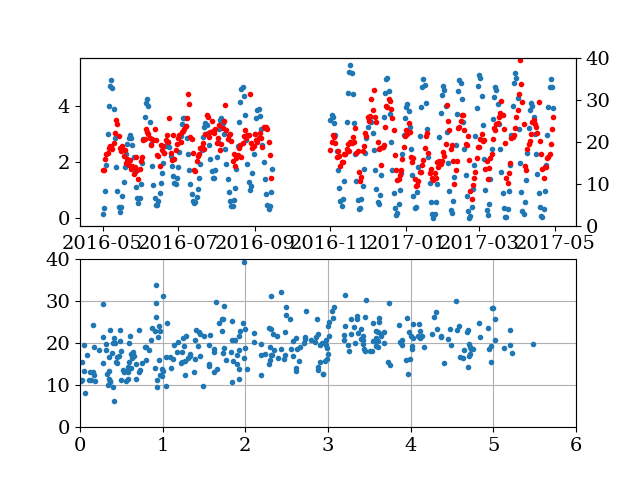

In [16]:
plt.figure()
plt.subplot(211)
#plt.plot(time, eta,'-',lw=0.2)
plt.plot(t, h_env**2.,'.')
#plt.plot(time, h_env2,'--')

ax2 = plt.twinx()
ax2.plot(t,data.a0.values,'r.')
ax2.set_ylim(0,40)


plt.subplot(212)
plt.plot(h_env**2.,data.a0.values,'.')
plt.xlim(0,6)
plt.ylim(0,40)
plt.grid(b=True)

<IPython.core.display.Javascript object>


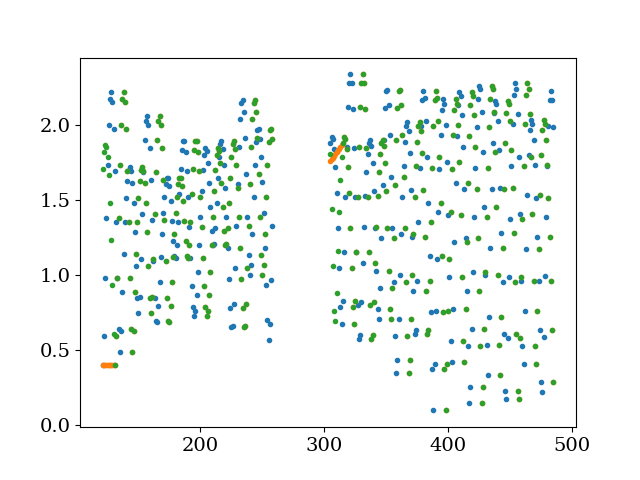

In [17]:
# Try a lagged regression

def lagtimeseries(x0, y0, lag):
    """
    x0 input x coordinate
    y0 input y coordinate
    
    x lagged value
    """
    lag = np.array(lag)
    x =  x0 - lag
    
    # Check the bounds
    x[x<x0[0]]=x0[0]
    x[x>x0[-1]]=x0[-1]


    idx = np.searchsorted(x0, x)
    #idx[idx<1]=1
    #shape=x0.shape[0]-1
    #idx[idx>shape]=shape
    
    # Nearest neighbour
    #return y0[idx - 1]

    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]


nlags = 20
lags = np.linspace(0,10,nlags)

tdays = tsec/86400

ylag = lagtimeseries(tdays, h_env, 10.)
ylag2 = sine_model_envelope(beta_s,omega,(tdays-10)*86400)

plt.figure()
plt.plot(tdays, h_env,'.')
plt.plot(tdays, ylag,'.')
plt.plot(tdays, ylag2,'.')


#with Model() as model:
#    coeff_sd = HalfCauchy('coeff_sd', 5)

    #y = GaussianRandomWalk('y', sd=coeff_sd, shape=(nlags,))

    #p = interpolate(knots, y, age,)

    #sd = HalfCauchy('sd', 5)

    #vals = Normal('vals', p, sd=sd, observed=rate)

In [40]:
from theano.compile.ops import as_op

@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dvector])
def lagtimeseries_pm(x0, y0, lag):
    """
    x0 input x coordinate
    y0 input y coordinate
    
    x lagged value
    """
    x =  x0 - lag
    
    # Check the bounds
    x[x<x0[0]]=x0[0]
    x[x>x0[-1]]=x0[-1]

    idx = tt.extra_ops.searchsorted(x0, x).eval()
    
    #return y0[idx - 1]

    dl = x - x0[idx - 1]
    dr = x0[idx] - x
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

def sine_model_envelope_pm(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    result = tt.zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = tt.zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
    return pm.math.sqrt(result*result + result_i*result_i)

# optimized a0
##lag = 2.02
Y = data.a0.values
tdays = SecondsSince(data.a0.index.values,basetime=basetime)/86400.
outputh5 = '../inputs/a0_samples_optimal_a0_all_times.h5'


# Harmonic a0
#lag = 1.6
#Y = a0_harmonic.values
#tdays = tdays_a0
#outputh5 = '../inputs/a0_samples_harmonic_a0_all_times.h5'


with pm.Model() as model:
    
    # Scale
    alpha1 = pm.HalfCauchy('alpha1', 10)
    #alpha2 = pm.HalfCauchy('alpha2', 10)
    #alpha3 = pm.HalfCauchy('alpha3', 10)

    
    # offset
    beta = pm.HalfCauchy('beta', 10)    
    sd = pm.HalfCauchy('sd', 10)
    
    #coeff_sd = pm.HalfNormal('sd_coeff', 1)

    # lag
    #ylag = lagtimeseries_pm(tt.as_tensor(tdays), tt.as_tensor(h_env), lag)


    #lag=2.02
    # Scalar lag
    #ylag = lagtimeseries(tdays, h_env, lag)
    
    # Non-scalar lag
    lag = pm.HalfCauchy('lag', 1.)
    #ylag = lagtimeseries_pm(tt.as_tensor(tdays), tt.as_tensor(h_env), lag)
    
    # Alternative approach is to compute the lagged envelope function directly
    tsec = (tt.as_tensor(tdays)-lag)*86400.
    ylag = sine_model_envelope_pm(beta_s, omega, tsec)
    #ylag = pm.Deterministic('ylag',sine_model_envelope_pm(beta_s, omega, tsec))

    #ylag
    #lag = lagtimeseries_pm(tdays, h_env, lag)
    # This is not really necessary
    #ylag = pm.Deterministic('ylag', lagtimeseries_pm(tt.as_tensor(tdays), tt.as_tensor(h_env), lag))


    
    # Mean function
    #mu = pm.Deterministic('mu', alpha1*ylag + beta)
    # Cubic polynomial
    #mu = pm.Deterministic('mu', alpha3*ylag*ylag*ylag + alpha2*ylag*ylag + alpha1*ylag + beta)
    

    vals = pm.Normal('vals', alpha1*ylag + beta, sd=sd, observed=Y)
    
    #start = {'lag':1.}
    #start= pm.find_MAP()
    start=None
    #step1 = pm.Metropolis(vars=[lag])
    #step2 = pm.NUTS(vars=[alpha1,beta,sd])
    trace = pm.sample(500, tune=1500,step = pm.NUTS(), start=start, chains=4)
    #trace = pm.sample(500, tune=1500,step =[step1,step2], start=start, chains=1)

    #print(pm.find_MAP())
    
    
pm.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lag, sd, beta, alpha1]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:14<00:00, 387.39draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha1,5.013553,0.532424,0.018455,3.993724,6.080551,777.383709,1.002306
beta,12.404287,0.812905,0.028738,10.758669,13.959471,776.986915,1.002989
sd,5.221416,0.207791,0.005252,4.857765,5.651708,1786.824378,1.001533
lag,0.943433,0.036685,0.000881,0.871583,1.016016,1448.302465,0.999885


/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


<IPython.core.display.Javascript object>


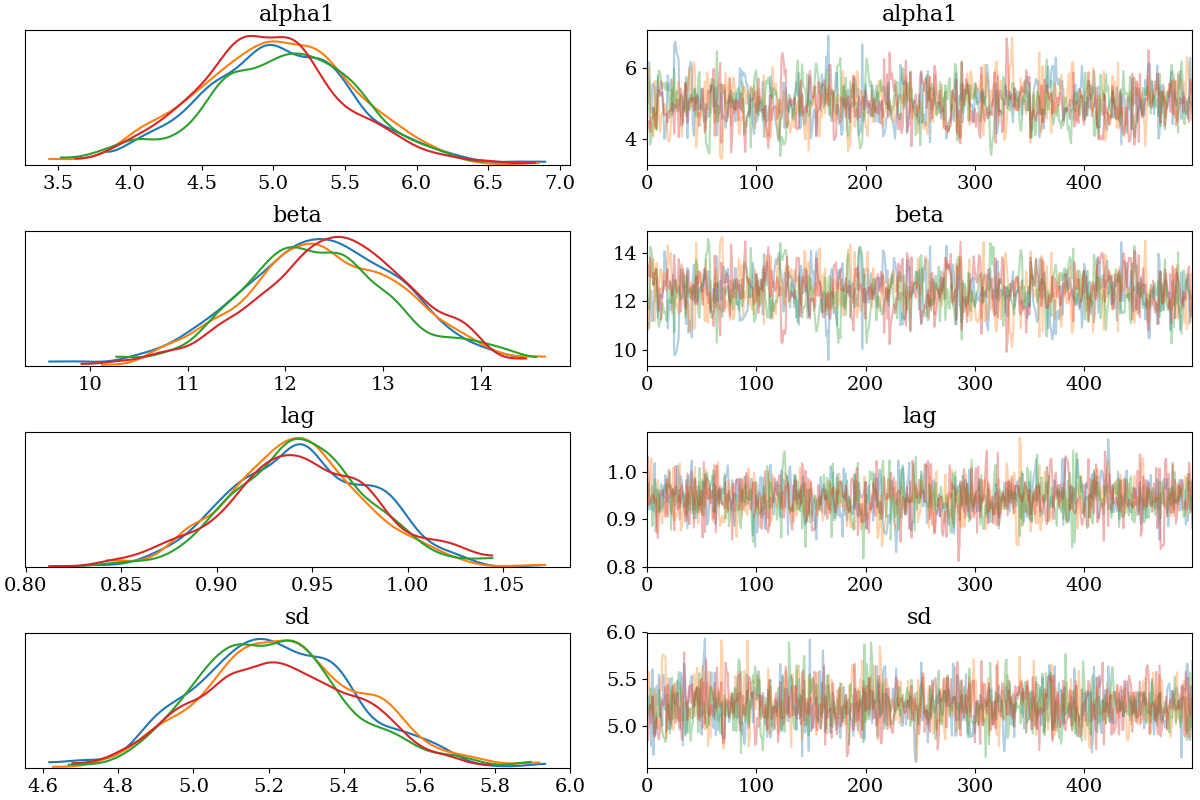

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7da2e87f0>,
      dtype=object)

In [41]:
pm.traceplot(trace,var_names=['alpha1','beta','lag','sd'])

In [42]:
# It seems like we cannot do the prediction along a new time axis 
# so we need to do it manually
def predict_a0(tnew, h, lag, alpha, beta, sigma):
    
    #ylag = lagtimeseries(tnew, h, lag)
    ylag= sine_model_envelope(np.array(beta_s), np.array(omega), (tnew-lag)*86400.)

    return alpha*ylag + beta + np.random.normal(scale=alpha,size=tnew.shape)

#tnew = pd.date_range('2016-01-01','2017-12-31',freq='12H').values
# Use the time from the density file
tnew = rhodata.index.values
tsecnew = SecondsSince(tnew,basetime=basetime)
tdaynew = tsecnew/86400.

h_new = sine_model_envelope(np.array(beta_s), np.array(omega), tsecnew)


nsamples = 1000
nt = tdaynew.shape[0]
a0_pred = np.zeros((nsamples, nt))
for ii,tr in enumerate(np.random.randint(0,nsamples,size=nsamples)):
    a0_pred[ii,:] = predict_a0(tdaynew, h_new, trace['lag'][tr], trace['alpha1'][tr], trace['beta'][tr], trace['sd'][tr])


<IPython.core.display.Javascript object>


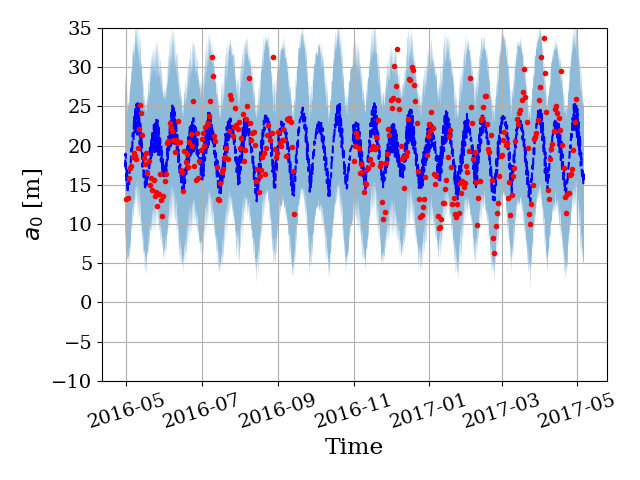

In [46]:
#trace.mu.shape, tdays.shape
plt.figure()
#plt.plot(tdays, np.median(samples['vals'],axis=0),'k--')
#plt.fill_between(tdays, np.percentile(samples['vals'],1.0,axis=0),\
#                 np.percentile(samples['vals'],99.,axis=0),alpha=0.5)

p1,=plt.plot(tnew, np.median(a0_pred,axis=0),'b--')
plt.fill_between(tnew, np.percentile(a0_pred,2.5,axis=0),\
                 np.percentile(a0_pred,97.5,axis=0),alpha=0.5)
#plt.fill_between(tdays, np.min(samples['vals'],axis=0),\
#                 np.max(samples['vals'],axis=0),)

plt.plot(data.index.values,data.a0.values,'r.')
#p2,=plt.plot(a0_harmonic.timeslow, a0_harmonic.values,'r.')


#ax2 = plt.twinx()
#ax2.plot(tdays,h_env,'g--')

#plt.xlim(100,500)
plt.ylim(-10,35)
plt.ylabel('$a_0$ [m]')
plt.xlabel('Time')
plt.xticks(rotation=17)
plt.grid(b=True)
plt.tight_layout()
plt.savefig(outputh5[:-3]+'.pdf')
plt.savefig(outputh5[:-3]+'.png',dpi=150)

In [47]:
# Output the data

f = h5py.File(outputh5,'w')
g = f.create_group('data')
g.create_dataset('a0-all-times-samples',data=a0_pred.T)
g.create_dataset('time',data=tdaynew)
f.close()
print(outputh5)

../inputs/a0_samples_optimal_a0_all_times.h5


In [ ]:
# Use minimization to find alpha, beta and tlag
def amp_response(coeffs,t, h_in):
    alpha, beta, lag = coeffs
    #ylag = lagtimeseries(t, h_in, lag)
    ylag = sine_model_envelope(beta_s, omega, t+lag)

    mu = alpha*ylag + beta
    
    return mu
def fdiff(coeffs, t, h_in, h_out):
    
    mu = amp_response(coeffs, t, h_in,)
    return np.linalg.norm(h_out - mu)

# Use the optimized a0
soln = minimize(fdiff, np.array([0,1,1]), args=(tdays, h_env, data.a0.values),
        )#bounds=[(0,10),(0,30),(0,30)])

# Use the harmonic a0 values 
soln2 = minimize(fdiff, np.array([0,1,1]), args=(tdays, h_env, a0_harmonic),
        )#bounds=[(0,10),(0,30),(0,30)])


h_op = amp_response(soln['x'], tdays, h_env)
h_op2 = amp_response(soln2['x'], tdays, h_env)

soln, soln2

<IPython.core.display.Javascript object>


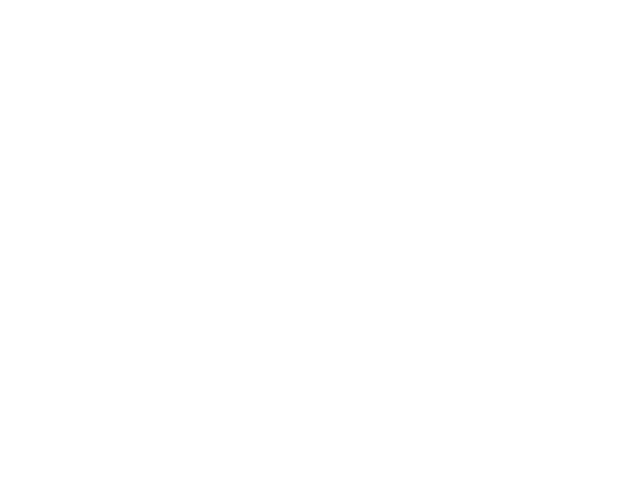

NameError: name 'samples' is not defined

In [56]:
plt.figure()
plt.plot(tdays, np.median(samples['vals'],axis=0),'k--')
plt.fill_between(tdays, np.percentile(samples['vals'],1.0,axis=0),\
                 np.percentile(samples['vals'],99.,axis=0),alpha=0.5)

plt.plot(tdays,data.a0.values,'r.')
plt.plot(tdays,a0_harmonic,'g.')


plt.plot(tdays,h_op,'--')
plt.plot(tdays,h_op2,'g--')


#ax2 = plt.twinx()
#ax2.plot(tdays,h_env,'g--')

plt.ylim(0,40)
plt.grid(b=True)

In [59]:
# Save the result to an amplitude hdf5 file
#testh5 = '../inputs/2018-05-22_a0-samples-at-all-times.h5'
outputh5 = '../inputs/a0_samples_optimal_a0_all_times.h5'

f = h5py.File(outputh5,'r')
for kk in f['data'].keys():
    print(kk)
    
print(f['data']['a0-all-times-samples'].shape)
f.close()

a0-all-times-samples
time
(1480, 1000)


In [60]:
print(a0_pred.shape)
f.close()

(1000, 1480)
